<a href="https://colab.research.google.com/github/Mustafa-Dara-Ozevin/ML_Algorithms_on_Kaggle_Datasets/blob/master/Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import copy
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns



In [0]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [0]:
print(df.shape)
print(df.isnull().sum())
print(df.isna().sum())


(1338, 7)
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [0]:
df['sex'].loc[df['sex'] == 'female'] = 0
df['sex'].loc[df['sex'] == 'male'] = 1
df['smoker'].loc[df['smoker'] == 'no'] = 0
df['smoker'].loc[df['smoker'] == 'yes'] = 1
df['region'].loc[df['region'] == 'southwest'] = 0
df['region'].loc[df['region'] == 'southeast'] = 1
df['region'].loc[df['region'] == 'northwest'] = 2
df['region'].loc[df['region'] == 'northeast'] = 3
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,0,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,2,21984.47061
4,32,1,28.880,0,0,2,3866.85520


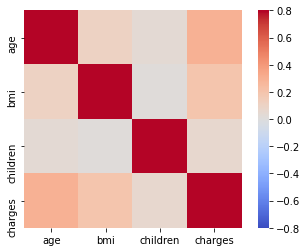

In [0]:
corrmat = df.corr()
sns.heatmap(corrmat, vmin=-.8, vmax=.8, square=True, cmap = 'coolwarm')

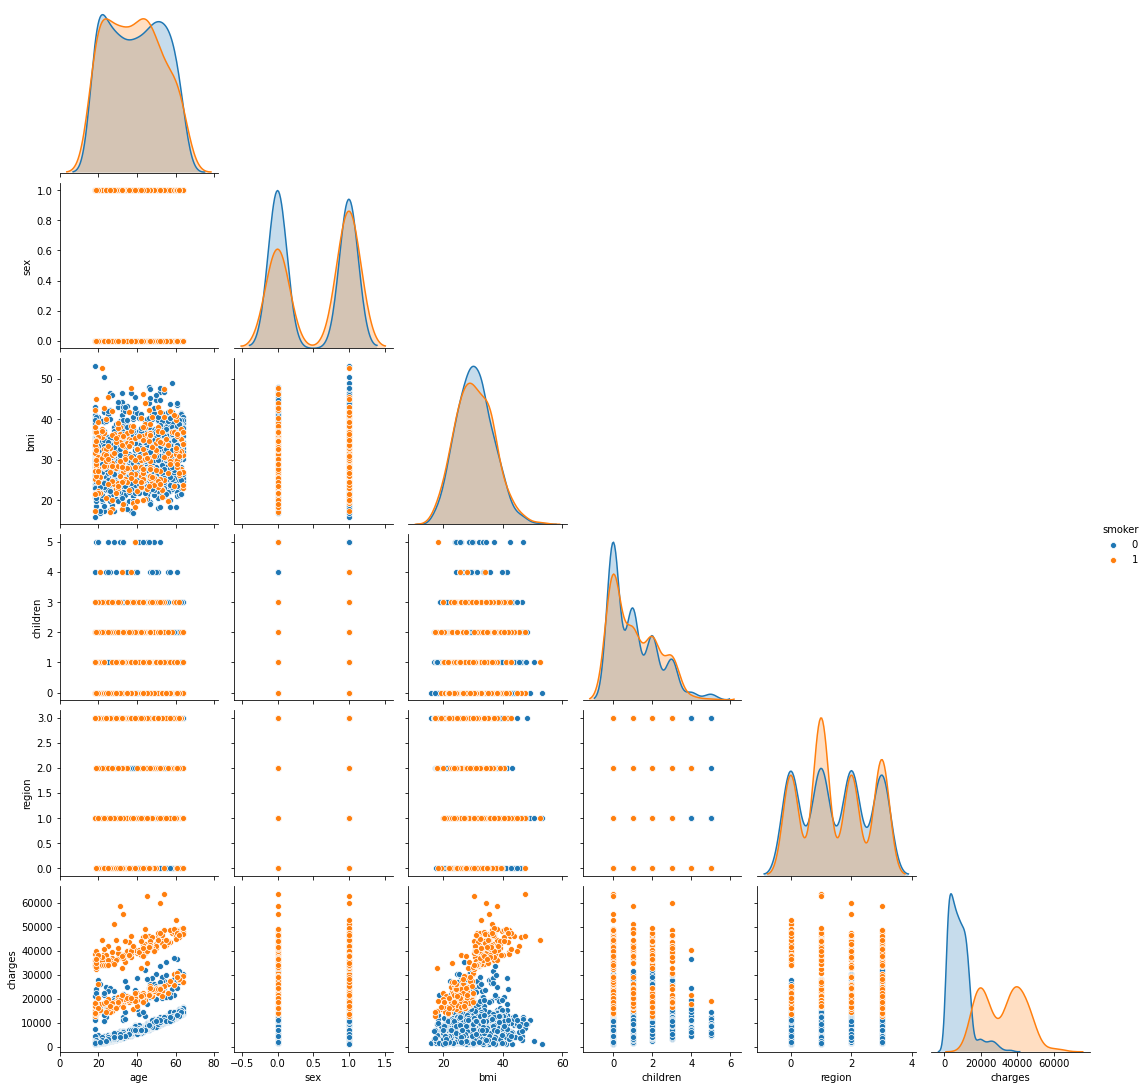

In [0]:
sns.pairplot(df,hue='smoker',corner=True)

In [0]:
scaler = MinMaxScaler()
scaler.fit(df.drop(labels='charges',axis=1))
df_transformed = scaler.transform(df.drop(labels='charges',axis=1))
X = pd.DataFrame(df_transformed)
y = df['charges']
X.columns = ['age','sex','bmi','children','smoker','region']
X.head()

,age,sex,bmi,children,smoker,region
0,0.021739,0.0,0.321227,0.0,1.0,0.000000
1,0.000000,1.0,0.479150,0.2,0.0,0.333333
2,0.217391,1.0,0.458434,0.6,0.0,0.333333
3,0.326087,1.0,0.181464,0.0,0.0,0.666667
4,0.304348,1.0,0.347592,0.0,0.0,0.666667


In [0]:
gbr = GradientBoostingRegressor()
gbr.fit(X, y)
feature_importances = gbr.feature_importances_

X_opt = X.copy()
removed_columns = pd.DataFrame()
models = []
r2_opt = []

for i in range(0,5):
    least_important = np.argmin(feature_importances)
    removed_columns = removed_columns.append(X_opt.pop(X_opt.columns[least_important]))
    gbr.fit(X_opt, y)
    feature_importances = gbr.feature_importances_
    accuracies = cross_val_score(gbr,
                                 X = X_opt,
                                 y = y, cv = 5,
                                 scoring = 'r2')
    r2_opt = np.append(r2_opt, accuracies.mean())
    models = np.append(models, ", ".join(list(X_opt)))
    
feature_selection = pd.DataFrame({'Features':models,'r2 Score':r2_opt})
feature_selection.head()

,Features,r2 Score
0,"age, bmi, children, smoker, region",0.855821
1,"age, bmi, children, smoker",0.854801
2,"age, bmi, smoker",0.849923
3,"bmi, smoker",0.752037
4,smoker,0.617801


In [0]:
for j in range(5):
  print(feature_selection.iloc[j,0])

age, bmi, children, smoker, region
age, bmi, children, smoker
age, bmi, smoker
bmi, smoker
smoker


In [0]:
X_best= df[['age','bmi','children','smoker']]
X_best.tail()

,age,bmi,children,smoker
1333,50,30.97,3,0
1334,18,31.92,0,0
1335,18,36.85,0,0
1336,21,25.80,0,0
1337,61,29.07,0,1


In [0]:
def print_results(results): # Function for printing results from GridSearchCV
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [0]:
gbr = GradientBoostingRegressor()
params_gbr ={ # Preparing the parameter combinations to test with GridSearchCV
    'learning_rate':[0.01,0.1,1],
    'n_estimators': [100,150,300],
    'max_depth': [3,9,18]
}
cv_gbr = GridSearchCV(gbr,params_gbr,cv=5) # creating the cv object with 5 cross validations
cv_gbr.fit(X_best,y) # fitting the model
print_results(cv_gbr) # Using print_result function to print results

BEST PARAMS: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}

0.739 (+/-0.034) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.814 (+/-0.043) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
0.858 (+/-0.056) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
0.712 (+/-0.035) for {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}
0.772 (+/-0.043) for {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 150}
0.792 (+/-0.05) for {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 300}
0.682 (+/-0.034) for {'learning_rate': 0.01, 'max_depth': 18, 'n_estimators': 100}
0.728 (+/-0.045) for {'learning_rate': 0.01, 'max_depth': 18, 'n_estimators': 150}
0.729 (+/-0.06) for {'learning_rate': 0.01, 'max_depth': 18, 'n_estimators': 300}
0.855 (+/-0.06) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.848 (+/-0.071) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
0.836 (+/-0.081) for {'le

In [0]:
y_pred = pd.DataFrame(cv_gbr.predict(X_best))
y_pred.columns = ['prediction']
df = df.join(y_pred)
df.head()

,age,sex,bmi,children,smoker,region,charges,prediction
0,19,0,27.900,0,1,0,16884.92400,18424.085432
1,18,1,33.770,1,0,1,1725.55230,4791.770626
2,28,1,33.000,3,0,1,4449.46200,6999.285765
3,33,1,22.705,0,0,2,21984.47061,5951.106572
4,32,1,28.880,0,0,2,3866.85520,4814.920847


In [0]:
df.to_csv('insurance_pred.csv')

In [0]:
joblib.dump(cv_gbr.best_estimator_,'GraidentBoostingRegressor.pkl')

['GraidentBoostingRegressor.pkl']

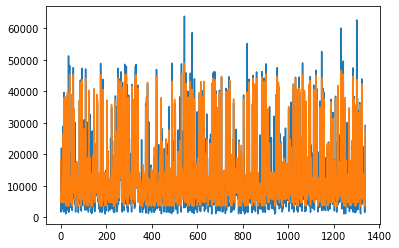

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(y)
ax.plot(y_pred)